<a href="https://colab.research.google.com/github/giulicrenna/data_science/blob/main/Covid_Argentina_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
!pip install chart_studio
!pip install bqplot
!pip install pingouin
!pip install pyarrow 
!pip install fastparquet

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.formula.api as sm
import pingouin
import os
from scipy.stats import ttest_ind, kstest
from sklearn.metrics import r2_score
from google.colab import drive
import pandas as pd

drive.mount('/content/gdrive')
sns.set_theme(style="darkgrid")

Mounted at /content/gdrive


In [ ]:
covidDataset = pd.read_parquet("/content/gdrive/MyDrive/Colab Notebooks/Covid19Casos.parquet", engine="fastparquet")
covidDataset.reset_index(inplace=True)

# Introducción
****
**Contexto Social:** El mundo ha sido azotado varias veces en la historia con pandemias que han dejado millones de muertos por detrás y han dejado secuelas que se extienden hasta nuestros días. La última pandemia producto del Covid 19, aunque catastrófica, nos ha dejado a diferencia de otras pandemias, un gran caudal de datos proveniente de diferentes fuentes a lo largo del globo que nos permitirán crear analisis y modelos analíticos a partir de los cuales podremos entender mejor como se desarrollan las epidemias y como podremos amortiguar los daños en futuras nuevas crisis globales de este estilo.
El gobierno nacional nos ha contratado para hacer análisis exploratorio y crear modelos predictivos en base a los datos recopilados a lo largo de estos dos últimos años.

**Problema Social:** Nuestra tarea será procesar, limpiar y hacer un posterior análisis de los datos, desarrollando nuestros propios modelos de machine learnig, los cuales nos ayudarán a entender mejor la problemática que estamos estudiando.

**Contexto analítico:** El gobierno nos proporcionará un archivo CSV que contiene todos los datos necesarios para poder realizar nuestro trabajo.
El dataset contiene las siguentes columnas:
- Sexo.
- Edad.
- Residencia. (país, provincia y departamento)
- Cuidados. intensivos (booleano)
- Fallecido. (booleano)
- Asistencia respiratoria mecánica. (booleano)
- Origen de financiamiento.
- Clasificación.
- Fecha de inicio de síntomas.
- Fecha de internación.
- Fecha de fallecimiento.
- Otros.

Tareas a realizar:
- Extraer los datos y posteriormente purgarlos.
- Leer y transformar los datos, y hacer visualizaciones.
- Hacer un análisis exploratorio. (EDA)
- Realizar modelos de machine learning.
- Realizar conclusiones.

Hay ciertas preguntas que nos gustaría responder previamente, las cuales nos ayudarán a abordar el análisis de los datos con mayor precisión y facilidad.

- ¿Cual es la cantidad de días entre el diágnostico de covid y el fallecimiento de la persona?
- ¿Existe alguna posibilidad de realizar una regresión lineal?

# Pregunta 1
Me interesaría saber cual es la cantidad de días entre el diágnostico de covid y el fallecimiento de la persona (Para los casos donde la persona efectivamente haya fallecido por covid)

In [ ]:
""" 
Cargo el dataset en una variable covidDatasetRestore ya que si hago un cambio al covidDataset lo puedo recuperar con el restore
Esto me sirve ya que el dataset al ser muy grande tarda mucho en ser cargado.
"""
covidDatasetRestore = covidDataset[covidDataset["edad"] < 107]
covidDataset = covidDatasetRestore
"""
Convierto las columnas de fechas en un formate dateTime de pandas.
"""
covidDataset.fecha_diagnostico = pd.to_datetime(covidDataset.fecha_diagnostico, errors = 'coerce') #  coerces any timestamps outside of the minimum or maximum range to NaT values.
covidDataset.fecha_fallecimiento = pd.to_datetime(covidDataset.fecha_fallecimiento, errors = 'coerce')
covidDataset["edad"] = covidDataset.edad.astype(int)
"""
Selecciono los casos dónde las personas hayan fallecido.
"""
covidFallecidos = covidDataset[covidDataset["fallecido"] == 'SI']

In [ ]:
"""
Esta función nos calcula el promedio de días entre el diagnóstico y la fecha de fallecimiento por edad
"""
def diferencia_fechas_por_edad(edad : int = 0) -> float:
  tempDataset = covidFallecidos[covidFallecidos["edad"] == edad]
  diferenciaSeries = tempDataset.fecha_fallecimiento - tempDataset.fecha_diagnostico
  return abs(float(round(diferenciaSeries.dt.days.mean(), 1)))

def diferencia_fechas_por_edad_no_prom(fecha_inicio, fecha_final) -> float:
  diferencia = pd.to_datetime(fecha_final) - pd.to_datetime(fecha_inicio)
  return abs(float(round(diferencia.days, 1)))

In [ ]:
"""
Creo un nuevo data frame donde almacenaré cada edad con el promedio de días.
"""
promDiasDataframe = pd.DataFrame()
edad_ = []
prom_dias = []

for edad in range(1, 115):
  try:
    prom_dias.append(diferencia_fechas_por_edad(edad))
    edad_.append(edad)
  except:
    pass

promDiasDataframe["edad"] = edad_
promDiasDataframe["prom_dias"] = prom_dias

In [ ]:
covidDataset['dias_internacion_hasta_muerte'] = covidDataset.fecha_fallecimiento - covidDataset.fecha_diagnostico
covidDataset['dias_internacion_hasta_muerte'] = covidDataset['dias_internacion_hasta_muerte'].abs().astype(str).str.replace('days', '').astype(int, errors = 'ignore')

Con este gráfico podemos visualizar más facilmente cuales son las edades que mas han días han durado con covid
antes de fallecer.

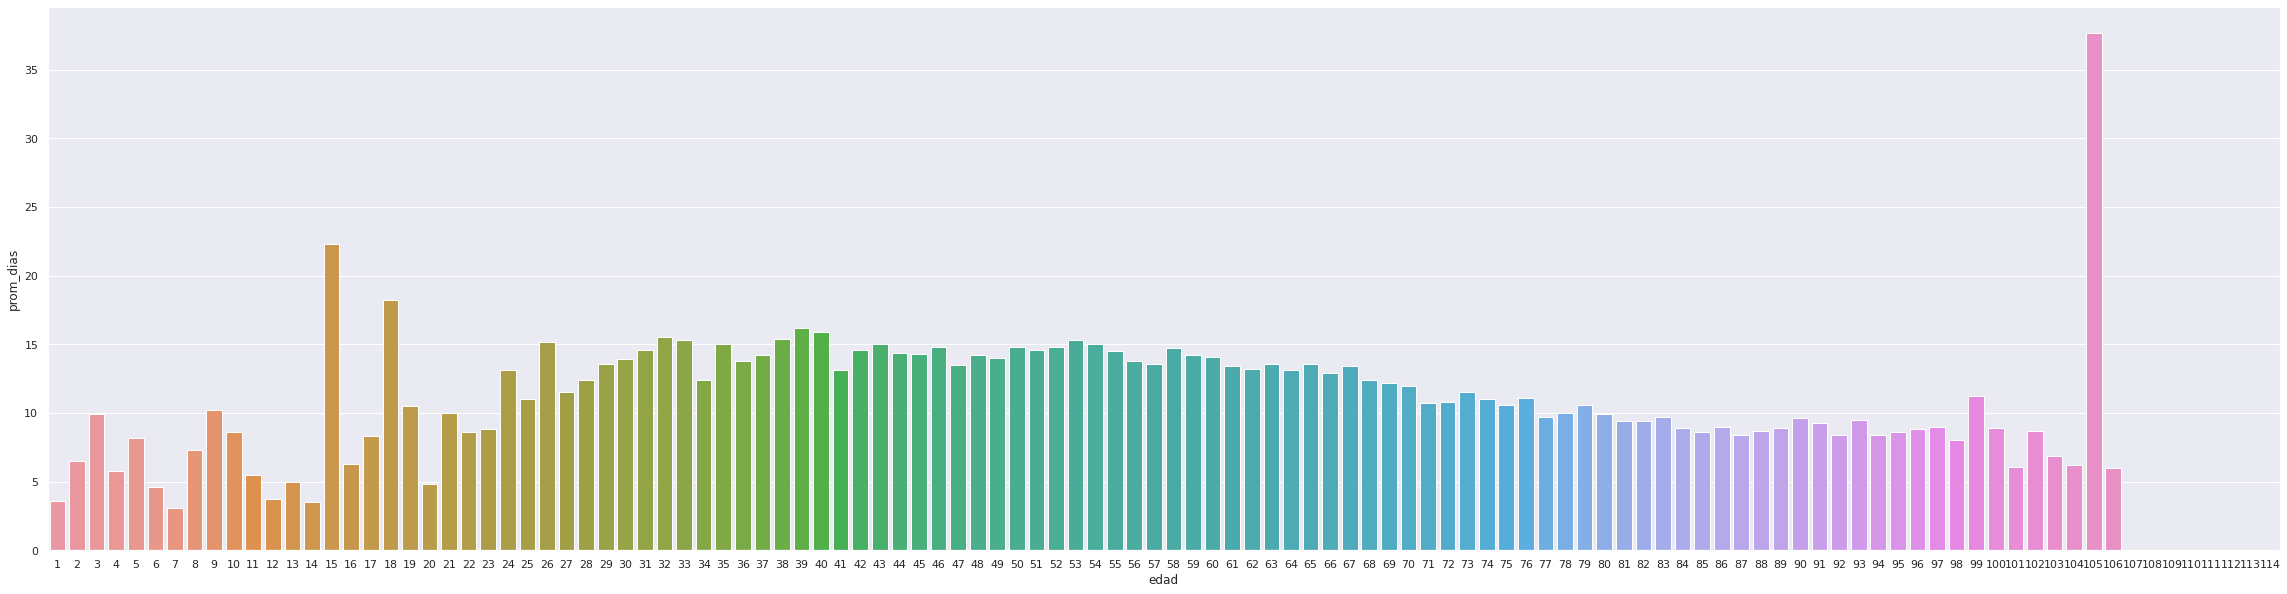

In [ ]:
f, ax = plt.subplots(figsize=(40, 10))
sns.barplot(data=promDiasDataframe, y = promDiasDataframe.prom_dias, x = promDiasDataframe.edad);

Ahora grafícaremos tomando el promedio en un rango de edad determinado.

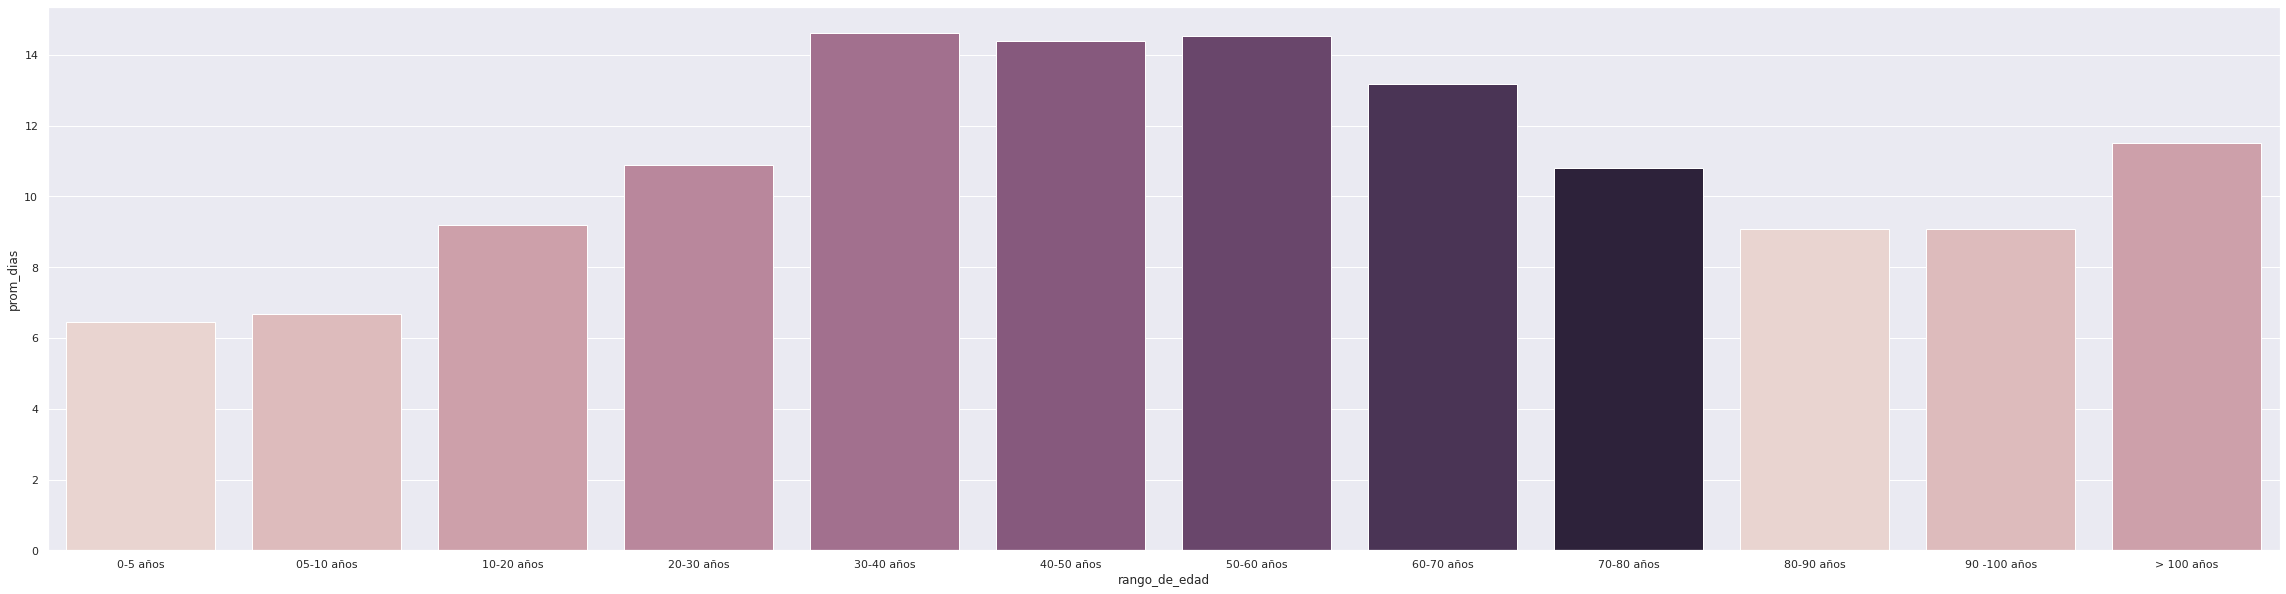

In [ ]:
colores = [[0.9312692223325372, 0.8201921796082118, 0.7971480974663592],
 [0.8888663743660877, 0.7106793139856472, 0.7158661451411206],
 [0.8314793143949643, 0.5987041921652179, 0.6530062709235388],
 [0.7588951019517731, 0.49817117746394224, 0.6058723814510268],
 [0.6672565752652589, 0.40671838146419587, 0.5620016466433286],
 [0.5529215689527474, 0.3217924564263954, 0.5093718054521851],
 [0.43082755198027817, 0.24984535814964698, 0.44393960899639856],
 [0.29794615023641036, 0.18145907625614888, 0.35317781405034754],
 [0.1750865648952205, 0.11840023306916837, 0.24215989137836502]]

dataFrame_copia = promDiasDataframe
dataFrame_copia.edad = dataFrame_copia.edad.astype(int)

condicion_edad = [
    (dataFrame_copia.edad < 5),
    (dataFrame_copia.edad >= 5) & (dataFrame_copia.edad < 10),
    (dataFrame_copia.edad >= 10) & (dataFrame_copia.edad < 20), 
    (dataFrame_copia.edad >= 20) & (dataFrame_copia.edad < 30),
    (dataFrame_copia.edad >= 30) & (dataFrame_copia.edad < 40),
    (dataFrame_copia.edad >= 40) & (dataFrame_copia.edad < 50),
    (dataFrame_copia.edad >= 50) & (dataFrame_copia.edad < 60),
    (dataFrame_copia.edad >= 60) & (dataFrame_copia.edad < 70),
    (dataFrame_copia.edad >= 70) & (dataFrame_copia.edad < 80),
    (dataFrame_copia.edad >= 80) & (dataFrame_copia.edad < 90),
    (dataFrame_copia.edad >= 90) & (dataFrame_copia.edad < 100),
    (dataFrame_copia.edad >= 100)
]


values_por_edad = ['0-5 años', '05-10 años', '10-20 años', '20-30 años', '30-40 años', '40-50 años', '50-60 años', '60-70 años', '70-80 años', '80-90 años', '90 -100 años', '> 100 años']
dataFrame_copia['rango_de_edad'] = np.select(condicion_edad, values_por_edad)

"""
Agrego el dato al dataset original.
"""

dataFrame_copia = dataFrame_copia.groupby(['rango_de_edad']).mean()
#dataFrame_copia = dataFrame_copia.drop(['edad'], axis=1)

f, ax = plt.subplots(figsize=(40, 10))
sns.barplot(data=dataFrame_copia, x = dataFrame_copia.index, y = dataFrame_copia.prom_dias, palette=colores);

El siguiente gráfico muestra la cantidad de personas que fallecieron de covid y que además usaron respiradores en el proceso, las unidades están en porcentajes en relacion a la cantidad de personas que fallecieron.

<AxesSubplot:xlabel='edad', ylabel='porcentaje_del_total'>

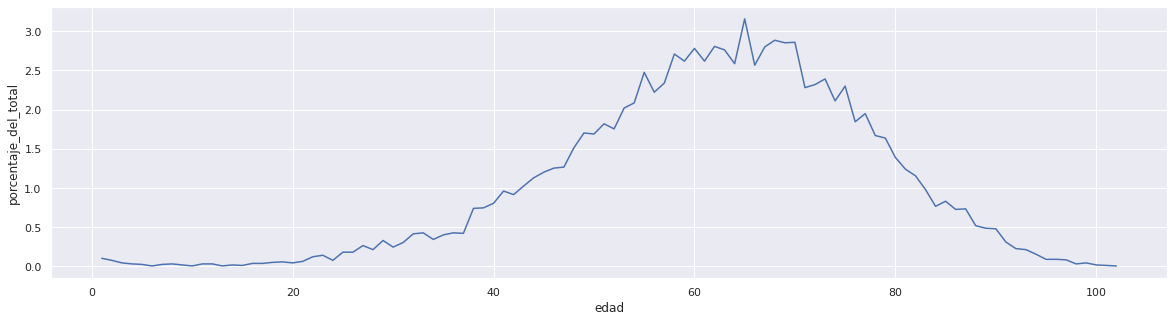

In [ ]:
fallecidos_con_respirador = covidFallecidos[(covidFallecidos.fallecido == 'SI') & (covidFallecidos.asistencia_respiratoria_mecanica == 'SI')]
fallecidos_con_respirador = fallecidos_con_respirador[['edad', 'fallecido']]
fallecidos_con_respirador.replace('SI', 1, inplace=True)

fallecidos_con_respirador_cantidad = fallecidos_con_respirador.groupby('edad').count()["fallecido"].tolist()
total = sum(fallecidos_con_respirador_cantidad)
porcentajes = [x * 100 / total for x in fallecidos_con_respirador_cantidad]

fallecidos_con_respirador = fallecidos_con_respirador.groupby('edad').count()
fallecidos_con_respirador['porcentaje_del_total'] = porcentajes

f, ax = plt.subplots(figsize=(20, 5))
sns.lineplot(x = fallecidos_con_respirador.index, y = fallecidos_con_respirador.porcentaje_del_total)

El siguiente gráfico muestra la cantidad de personas que fallecieron de covid y que además estuvieron en cuidados intensivos, las unidades están en porcentajes en relacion a la cantidad de personas que fallecieron.

<AxesSubplot:xlabel='edad', ylabel='porcentaje_del_total'>

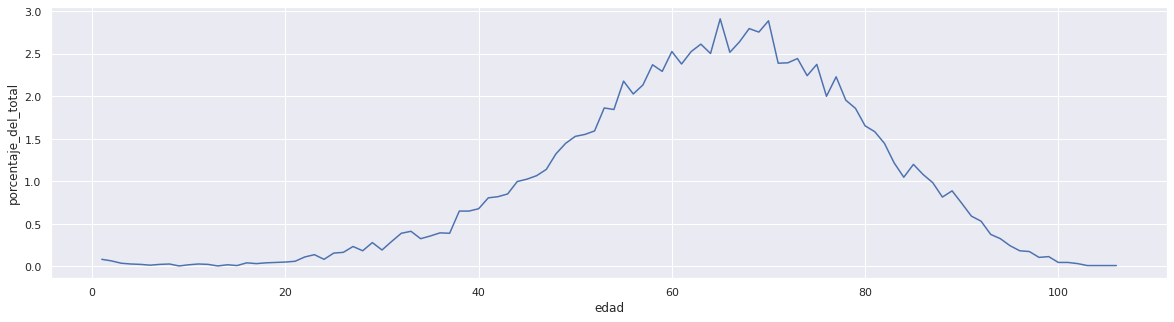

In [ ]:
fallecidos_con_respirador = covidFallecidos[(covidFallecidos.fallecido == 'SI') & (covidFallecidos.cuidado_intensivo == 'SI')]
fallecidos_con_respirador = fallecidos_con_respirador[['edad', 'fallecido']]
fallecidos_con_respirador.replace('SI', 1, inplace=True)

fallecidos_con_respirador_cantidad = fallecidos_con_respirador.groupby('edad').count()["fallecido"].tolist()
total = sum(fallecidos_con_respirador_cantidad)
porcentajes = [x * 100 / total for x in fallecidos_con_respirador_cantidad]

fallecidos_con_respirador = fallecidos_con_respirador.groupby('edad').count()
fallecidos_con_respirador['porcentaje_del_total'] = porcentajes

f, ax = plt.subplots(figsize=(20, 5))
sns.lineplot(x = fallecidos_con_respirador.index, y = fallecidos_con_respirador.porcentaje_del_total)

El siguiente gráfic nos muestra la diferencia entre la cantidad de personas que usaron estuvieron en cuidados intensivos que no fallecieron y la cantidad de personas en cuidados intensivos que fallecieron.

<AxesSubplot:xlabel='edad', ylabel='diferencia'>

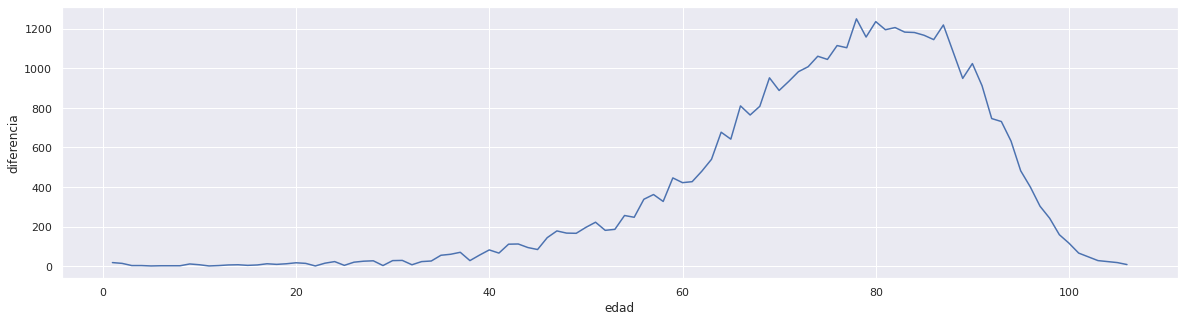

In [ ]:
fallecidos_con_respirador = covidFallecidos[(covidFallecidos.fallecido == 'SI') & (covidFallecidos.cuidado_intensivo == 'SI')]
con_respirador = covidFallecidos[(covidFallecidos.fallecido == 'SI') & (covidFallecidos.cuidado_intensivo == 'NO')]

fallecidos_con_respirador = fallecidos_con_respirador[['edad', 'fallecido']]
fallecidos_con_respirador.replace('SI', 1, inplace=True)

con_respirador = con_respirador[['edad', 'fallecido']]
con_respirador = con_respirador.replace('SI', 1)

fallecidos_con_respirador_cantidad = fallecidos_con_respirador.groupby('edad').count()
con_respirador_cantidad = con_respirador.groupby('edad').count()

fallecidos_con_respirador_cantidad_ = fallecidos_con_respirador_cantidad['fallecido'].tolist() 
con_respirador_cantidad_ = con_respirador_cantidad['fallecido'].tolist()

diferencia = [abs(e1 - e2) for e1, e2 in zip(con_respirador_cantidad_, fallecidos_con_respirador_cantidad_)]

fallecidos_con_respirador_cantidad['diferencia'] = diferencia
fallecidos_con_respirador_cantidad

fallecidos_con_respirador_cantidad = fallecidos_con_respirador_cantidad.groupby('edad').mean()

f, ax = plt.subplots(figsize=(20, 5))
sns.lineplot(x = fallecidos_con_respirador_cantidad.index, y = fallecidos_con_respirador_cantidad.diferencia)

# Pregunta 2
Ahora me interesaría realizar un scatter plot para poder ver si existe alguna posibilidad de realizar una regresión lineal.

In [ ]:
"""
genero el dataset con los el time delta de cada fila.
"""
scatterDataSet = covidFallecidos[["edad", "fecha_fallecimiento", "fecha_diagnostico"]]
singleDay = []
for index, row in scatterDataSet.iterrows():
  try:
    day = diferencia_fechas_por_edad_no_prom(row[1], row[2])
    singleDay.append(day)
  except Exception as e:
    pass

scatterDataSet["days"] = singleDay;
scatterDataSet = scatterDataSet.dropna()

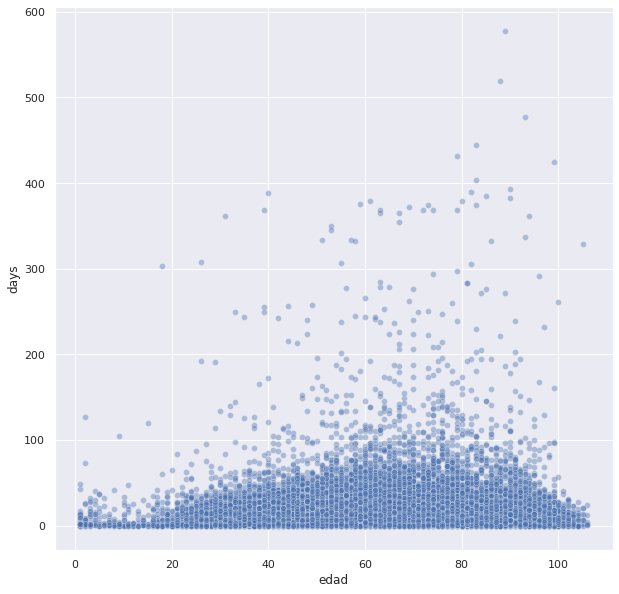

In [ ]:
f, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=scatterDataSet, x = scatterDataSet.edad, y = scatterDataSet.days, alpha=0.4);

Ahora analizo las columnas para hacer los tests.

In [ ]:
modelo1 = "edad~days"
md1 = sm.ols(formula = modelo1, data = scatterDataSet).fit()
print(md1.summary())

                            OLS Regression Results                            
Dep. Variable:                   edad   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     949.6
Date:                Fri, 03 Mar 2023   Prob (F-statistic):          2.76e-207
Time:                        20:46:36   Log-Likelihood:            -3.3127e+05
No. Observations:               79487   AIC:                         6.625e+05
Df Residuals:                   79485   BIC:                         6.626e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     70.8588      0.068   1036.057      0.0

In [ ]:
pval = kstest(scatterDataSet.days, scatterDataSet.edad).pvalue
r2 = r2_score(scatterDataSet.days, scatterDataSet.edad)

print("El pval del modelo es: {}".format(pval))
print("El puntaje R2 es: {}".format(r2))

El pval del modelo es: 0.0
El puntaje R2 es: -12.035537232478193


Al ser el p-val menor a 0.05, es un valor válido.
Al ser el R2 negativo nos indica una alta variabilidad de los datos,
no podremos realizar un modelo de regresión lineal para los mismos.

# Detección de outliers
Buscaremos dentro de un DataFrame reducido outliers usando sklearn.

Usaremos un método de detección multivariable.

Sabemos que existe una distribusión gausiana de los datos.

In [ ]:
from sklearn.covariance import EllipticEnvelope

outliers = EllipticEnvelope(contamination=0.01, support_fraction=1)

covidDataset_ = covidDataset
covidDataset_ = covidDataset_[['edad', 'dias_internacion_hasta_muerte']].dropna()
covidDataset_ = covidDataset_[covidDataset_['dias_internacion_hasta_muerte'] != 'NaT']
columns = covidDataset_.columns.values.tolist()

selection_arr = np.array(covidDataset_[columns].values)
outliers.fit(selection_arr);
selection_arr

array([[55, '13 '],
       [47, '15 '],
       [52, '17 '],
       ...,
       [68, '11 '],
       [90, '34 '],
       [63, '12 ']], dtype=object)

Predecimos y detectamos las posiciones de los outliers en forma multi-variable.

Posteriormente limpiamos el dataset.

In [ ]:
pred = outliers.predict(selection_arr)
pred

pos_outliers = np.where(pred == -1)
pos_outliers = pos_outliers[0].tolist()
pos_outliers

try:
  covidDataset = covidDataset.drop(pos_outliers, axis=0)
except:
  pass
print(f'se limparon {len(pos_outliers)} outliers del el conjunto de datos.')

se limparon 795 outliers del el conjunto de datos.


# Feature selection por forward selection.

In [ ]:
import statsmodels.api as sm
def forward_selection(data, target, significance_level=0.01):
    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<significance_level):
            best_features.append(new_pval.idxmin())
        else:
            break
    return best_features

In [ ]:
covidDataset_

,edad,dias_internacion_hasta_muerte
83,55,13
89,47,15
643,52,17
815,83,8
888,62,0
...,...,...
13997216,73,1
13997456,81,7
13997576,68,11
13998645,90,34


In [ ]:
Y =  covidDataset_['edad']
forward_selection(covidDataset_.astype(int),Y)

<ipython-input-20-a6ce63c591b0>:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
<ipython-input-20-a6ce63c591b0>:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)


['edad']

In [ ]:
import sys
import joblib
sys.modules['sklearn.externals.joblib'] = joblib

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression

sfs = SFS(LinearRegression(),
          k_features=2,
          forward=True,
          floating=False,
          scoring = 'r2',
          cv = 0)

In [ ]:
sfs.fit(covidDataset_, Y)
sfs.k_feature_names_   

('edad', 'dias_internacion_hasta_muerte')

# Entrenamos nuestro modelo de clustering

In [ ]:
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

datos = covidDataset[['edad', 'dias_internacion_hasta_muerte']].dropna()
datos = datos[datos['dias_internacion_hasta_muerte'] != 'NaT'].astype(int)

#datos = datos.fillna(0)

datos_x = covidDataset.edad.tolist()
datos_y = covidDataset.dias_internacion_hasta_muerte.tolist()

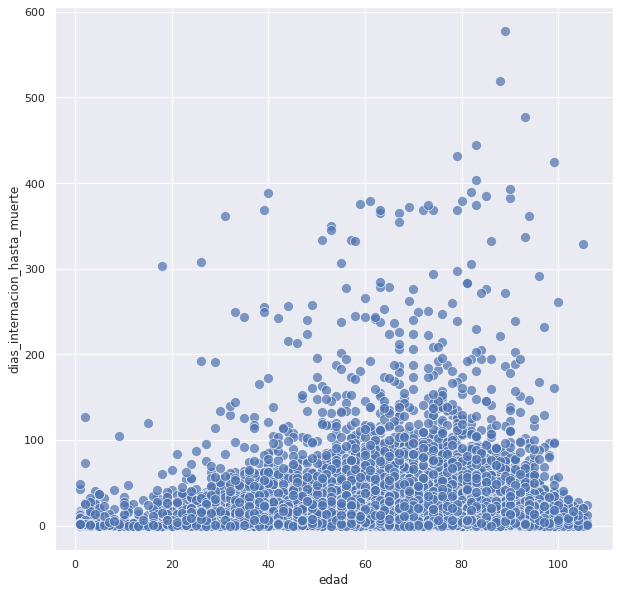

In [ ]:
plt.figure(figsize=(8, 8));
plot = sns.scatterplot(data=datos[['dias_internacion_hasta_muerte', 'edad']],
                y='dias_internacion_hasta_muerte',
                x='edad',      
                legend=False,
                s = 100,
                #palette = sns.color_palette("husl",6),
                alpha=0.7).tick_params(left=False) ;

In [ ]:
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn import metrics

datos_escalados = preprocessing.scale(datos)

In [ ]:
datos_escalados.mean(axis=0)

array([ 1.43034697e-17, -5.68562920e-17])

In [ ]:
kmeans = KMeans(n_clusters=3,  
                random_state=0).fit(datos)
kmeans.labels_ # Nos indica a que cluster pertenece cada observación

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([1, 1, 1, ..., 0, 0, 1], dtype=int32)

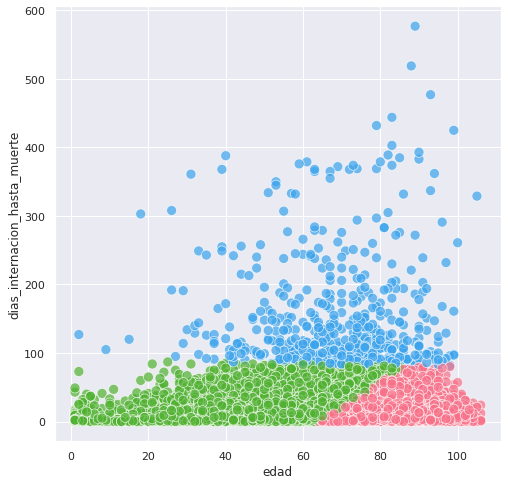

In [ ]:
plt.figure(figsize=(8,8));
sns.scatterplot(x=datos.edad,
                y = datos.dias_internacion_hasta_muerte,
                hue = kmeans.labels_,
                s = 100,
                alpha = 0.7,
                palette = sns.color_palette("husl", 3),
                legend=False);

# Aplicamos otras métricas.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [ ]:
data_x = datos.drop('edad', axis=1)
data_y = datos['edad']

X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.3, random_state=1)

In [ ]:
modelo = RandomForestClassifier(random_state=1)
modelo.fit(X_train, y_train)
preds = modelo.predict(X_test) 

Nuestro modelo de clustereing tiene una exactitud del 2.76% y una presición del 52.82% aunque la presición es "aceptable", la exactitud no.
Eso significa que tendré que buscar una mejor forma de entrenar los modelos de machine learning.

In [ ]:
print(f'Exactitud del modelo: {metrics.accuracy_score(y_test, preds)*100}%')
print(f'Presición del modelo: {metrics.precision_score(y_test, preds, average=None, zero_division=True).mean()*100}%')

Exactitud del modelo: 2.7175508492346405%
Presición del modelo: 48.81148451451447%
